## Assignment 4
* Train a CNN for CIFAR-10 with the best hyperparameters possible
* Visualize activations after each Conv filter
* Visualize kernel of each Conv filter
* Which one is working better in CIFAR-10, MaxPooling or AvgPooling or concatination of both

Training a CNN model (EfficientNet design) with CIFAR-10 dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

class Block(nn.Module):

    def __init__(self, in_channels, out_channels, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        channels = expansion * in_channels
        self.conv1 = nn.Conv2d(
            in_channels, channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3,
                               stride=stride, padding=1, groups=channels, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
        self.conv3 = nn.Conv2d(
            channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # SE layers
        self.fc1 = nn.Conv2d(out_channels, out_channels//16, kernel_size=1)
        self.fc2 = nn.Conv2d(out_channels//16, out_channels, kernel_size=1)

    def forward(self, x):
        global count
        
        o1 = self.conv1(x)
        out = F.relu(self.bn1(o1))

        count +=1

        if(count < 10):
          plt.figure()
          plt.title("activation")
          plt.imshow(out[1][0].cpu().data.numpy())
          plt.figure()
          plt.title("kernal")
          plt.imshow(o1[1][0].cpu().data.numpy())

        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        shortcut = self.shortcut(x) if self.stride == 1 else out
        # Squeeze-Excitation
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = self.fc2(w).sigmoid()
        out = out * w + shortcut
        return out


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=10):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(cfg[-1][1], num_classes)

    def _make_layers(self, in_channels):
        layers = []
        for expansion, out_channels, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_channels, out_channels, expansion, stride))
                in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def EfficientNetB0():
    # (expansion, out_Channels, num_blocks, stride)
    cfg = [(1,  16, 1, 2),
           (6,  24, 2, 1),
           (6,  40, 2, 2),
           (6,  80, 3, 2),
           (6, 112, 3, 1),
           (6, 192, 4, 2),
           (6, 320, 1, 2)]
    return EfficientNet(cfg)


def test():
    net = EfficientNetB0()
    x = torch.randn(2, 3, 32, 32)
    y = net(x)
    print(y.shape)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Normalize training data (zero mean and variance of 1)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

#trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
net = EfficientNetB0()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)


Epoch: 0
accuracy =  52.29 %

Epoch: 1
accuracy =  55.59 %

Epoch: 2
accuracy =  64.15 %

Epoch: 3
accuracy =  65.77 %

Epoch: 4
accuracy =  69.02 %

Epoch: 5
accuracy =  69.31 %

Epoch: 6
accuracy =  70.48 %

Epoch: 7
accuracy =  70.26 %

Epoch: 8
accuracy =  70.3 %

Epoch: 9
accuracy =  70.66 %

Epoch: 10
accuracy =  71.17 %

Epoch: 11
accuracy =  71.12 %


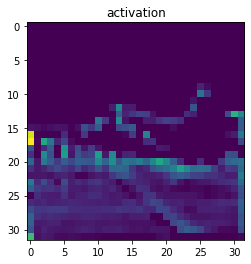

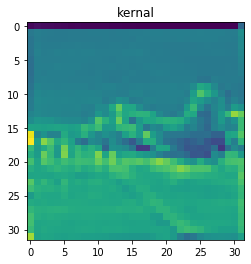

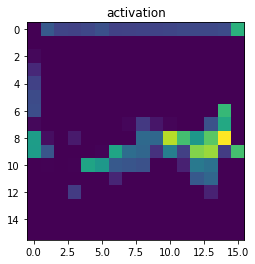

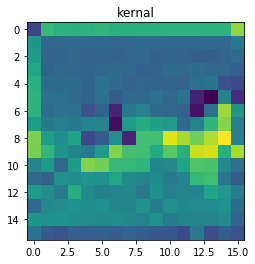

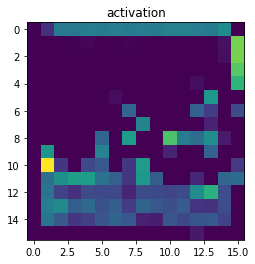

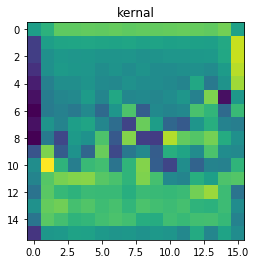

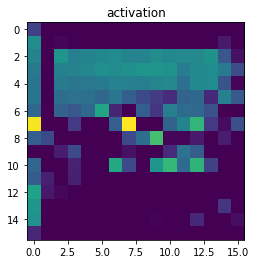

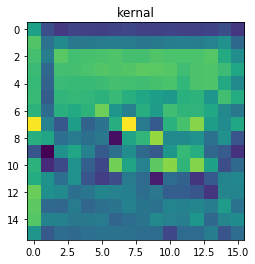

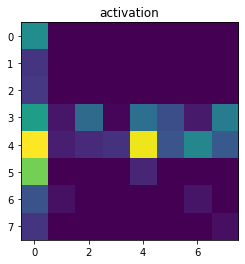

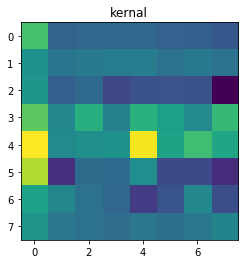

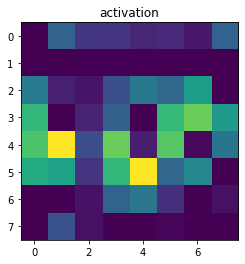

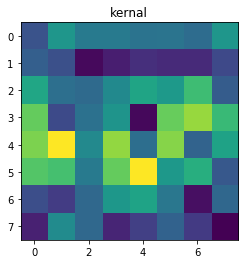

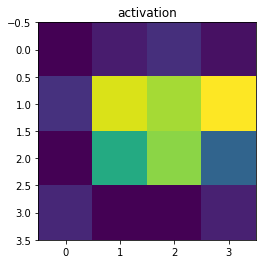

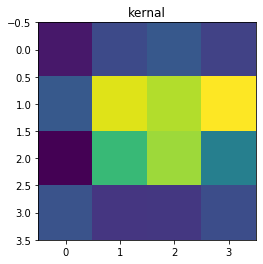

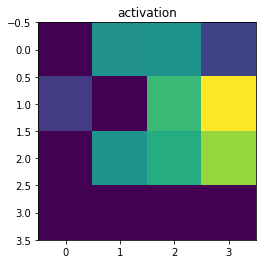

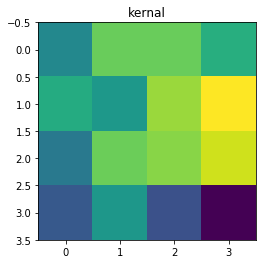

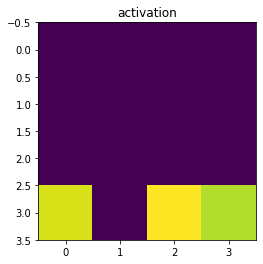

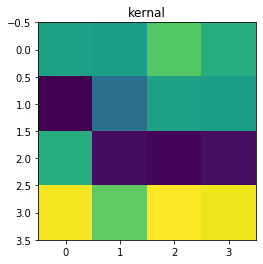

In [ ]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    print("accuracy = ", acc,"%"  )

count = 0

for epoch in range(num_epochs):
    train(epoch)
    test(epoch)


With max pooling

In [ ]:
class Block(nn.Module):
  def forward(self, x):
        o1 = self.conv1(x)
        out = F.relu(self.bn1(o1))
          
        plt.title("activation")
        plt.imshow(out[1][0].cpu().data.numpy())

        plt.title("kernal")
        plt.imshow(o1[1][0].cpu().data.numpy())

        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        shortcut = self.shortcut(x) if self.stride == 1 else out
        # Squeeze-Excitation
        w = F.max_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = self.fc2(w).sigmoid()
        out = out * w + shortcut
        return out
        
for epoch in range(num_epochs):
    train(epoch)
    test(epoch)


Epoch: 0
accuracy =  71.84 %

Epoch: 1
accuracy =  70.48 %

Epoch: 2
accuracy =  71.83 %

Epoch: 3
accuracy =  71.84 %

Epoch: 4
accuracy =  71.95 %

Epoch: 5
accuracy =  72.04 %

Epoch: 6
accuracy =  72.09 %

Epoch: 7
accuracy =  72.28 %

Epoch: 8
accuracy =  72.72 %

Epoch: 9
accuracy =  72.74 %

Epoch: 10
accuracy =  72.22 %

Epoch: 11
accuracy =  72.62 %


Q4:  It is worth noting that the only difference between FC and CONV layers is that the neurons in the CONV layer are connected only to a local region in the input and that many of the neurons in a CONV volume share parameters. However, the neurons in both layers still compute dot products, so their functional form is identical.
Thus to convert an FC layer Conv layer set the filter size(n) to be exactly the size of the input volume, and hence the output will be equivalent to a FC layer.